In [45]:
import os
from os import walk
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib import cm
%matplotlib inline 
import numpy as np
matplotlib.rcParams['figure.figsize'] = (20, 12)
import pandas as pd
from medpy.io import load
import random
import PIL
from PIL import Image

In [2]:
def get_image_array(filename, mask = False):
    if mask == False:
        file_dir = os.path.join('./luna16_nodules/nodule_patches/',filename)
    else:
        file_dir = os.path.join('./luna16_nodules/segmentation/',filename)
    img = sitk.ReadImage(file_dir)
    img_arr = sitk.GetArrayFromImage(img)
    img_arr_2d = np.array(img_arr[:,:,25])
    return img_arr, img_arr_2d

In [3]:
''' 
Class which could be useful for storing and accessing all data
and metadata for one patch
''' 
class Patch:
    def __init__(self, data, spacing, offset, direction, mask):
        self.data    = data,
        self.spacing = spacing,
        self.offset  = offset,
        self.direction = direction,
        self.mask    = mask #bool if mask or not
        
    def get_data(self):
        return self.data[0]

In [6]:
#helper function which returns image array given a filename
def create_patch_from_file(filename, mask = False):
    if mask == False:
        file_dir = os.path.join('./Data/luna16_nodules/nodule_patches/',filename)
    else:
        file_dir = os.path.join('./Data/luna16_nodules/segmentation/',filename)
    image_data, image_header = load(file_dir)
    spacing = image_header.get_voxel_spacing()
    offset = image_header.get_offset()
    direction = image_header.get_direction()
    
    return Patch(image_data, spacing, offset, direction, mask)

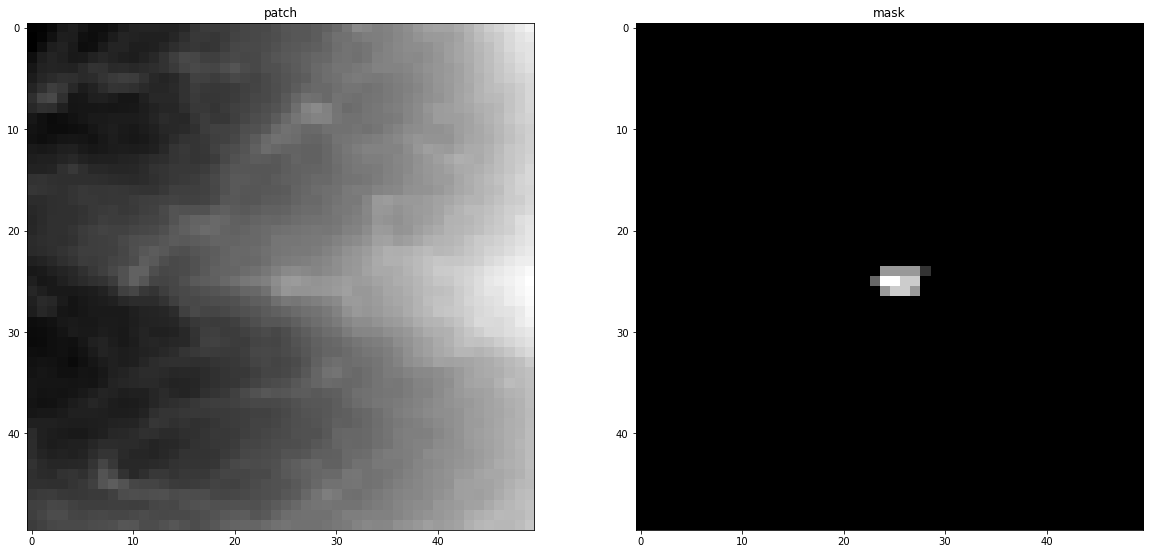

In [7]:
#Plots the patch for certain filename
patch_file = '1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_dcm_0.mha'
mask_file = '1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_seg_0.mha'

patch = create_patch_from_file(patch_file)
mask = create_patch_from_file(mask_file, mask = True)

plt.subplot(121)
plt.imshow(patch.get_data().sum(0).T, cmap='gray')
plt.title('patch')
plt.subplot(122)
plt.imshow(mask.get_data().sum(0).T, cmap='gray')
plt.title('mask')

plt.show()

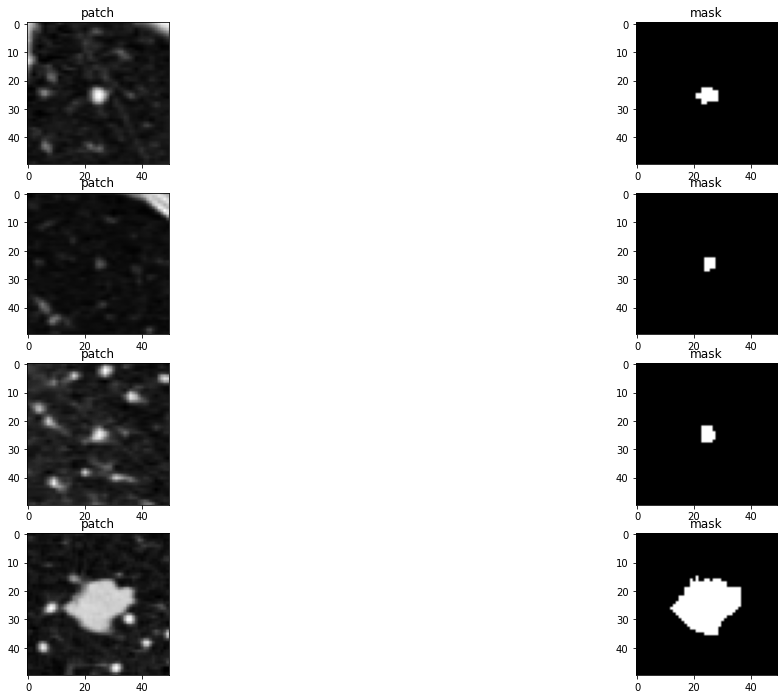

In [14]:
#Plots the first 4 patches
_, _, patch_names = next(walk('./Data/luna16_nodules/nodule_patches'))
_, _, mask_names = next(walk('./Data/luna16_nodules/segmentation'))


for index in range(4):
    patch = create_patch_from_file(patch_names[index])
    mask = create_patch_from_file(mask_names[index], mask = True)
    
    # visualize the two numpy arrays
    plt.subplot(4, 2, index*2+1)
    plt.imshow(patch.get_data()[25,:,:], cmap='gray')
    plt.title('patch')
    
    plt.subplot(4, 2, index*2+2)
    plt.imshow(mask.get_data()[25,:,:], cmap='gray')
    plt.title('mask')
     
plt.show()


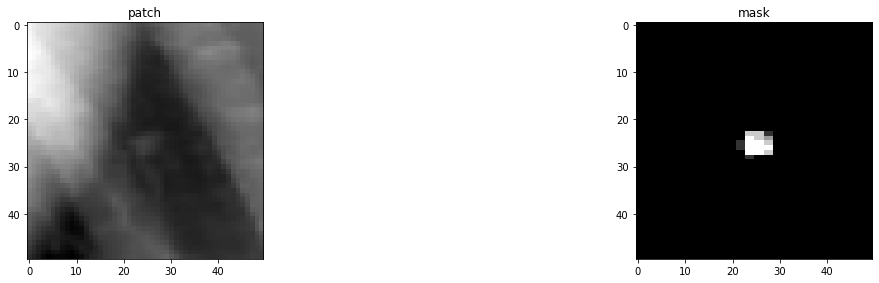

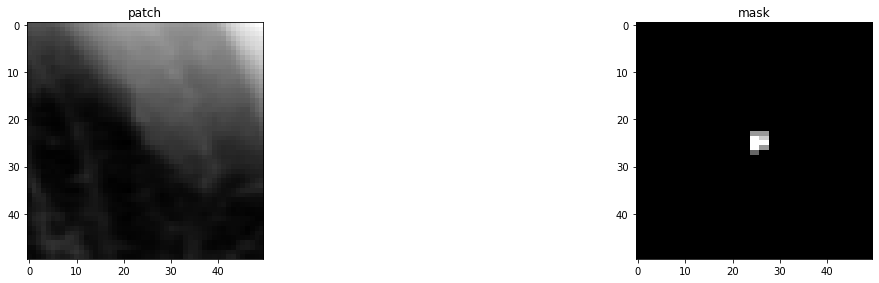

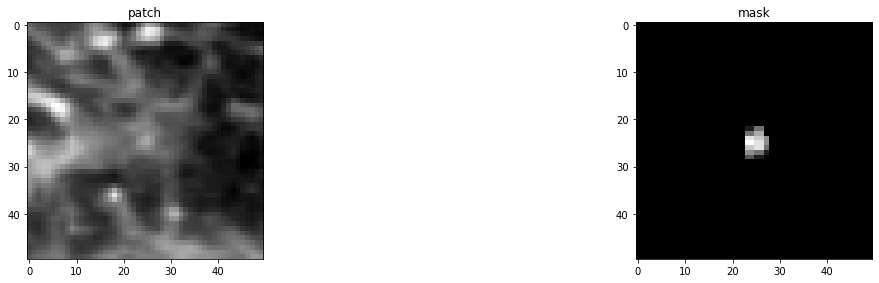

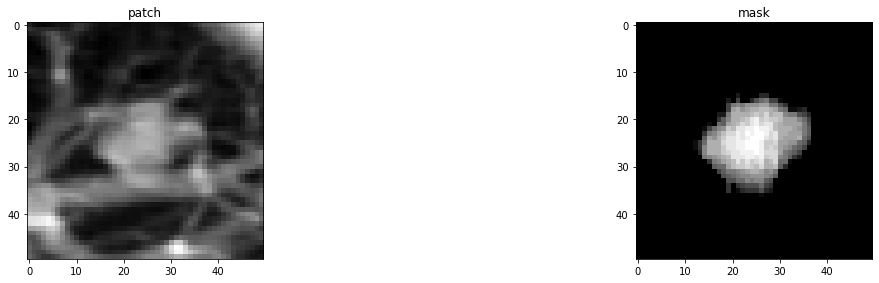

In [15]:
#Plots the first 8 patches as xray

for index in range(4):    
    #plt.imshow(patch_xray, norm=colors.PowerNorm(gamma=3), cmap=plt.cm.bone)
    patch = create_patch_from_file(patch_names[index])
    mask = create_patch_from_file(mask_names[index], mask = True)

    fig = plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, index*2+1)
    plt.imshow(patch.get_data().sum(0), cmap='gray')
    plt.title('patch')
    
    plt.subplot(4, 2, index*2+2)
    plt.imshow(mask.get_data().sum(0), cmap='gray')
    plt.title('mask')
     
plt.show()

'\nmasked_cxr /= np.amax(np.abs(masked_cxr))\nmasked_cxr *= (255.0/masked_cxr.max())\nprint(normalized_cxr)\n'

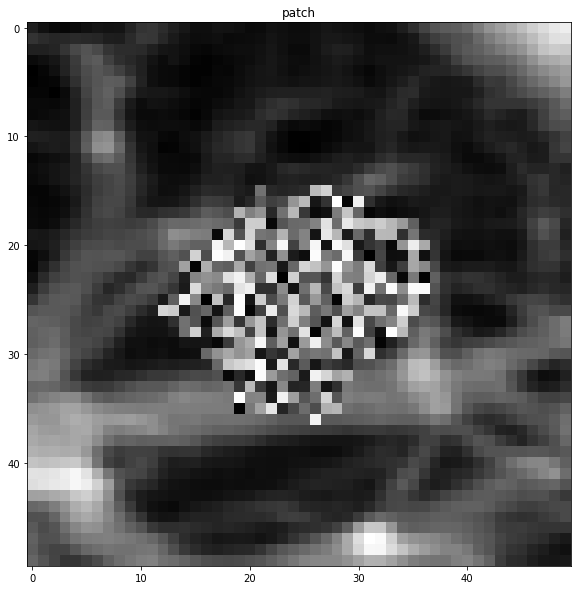

In [70]:
def place_mask(cxr, mask):
    '''
    give this 2d array and 2d mask
    places random gray value on cxr pixel if mask value > 0
    '''
    max_val = int(np.max(cxr))
    min_val = int(np.min(cxr))
    random_mask = np.random.randint(min_val,max_val,[50,50])
    masked_cxr = np.where(mask > 0, random_mask, cxr)
    return masked_cxr

masked_cxr = place_mask(patch.get_data().sum(0),mask.get_data().sum(0))

fig = plt.figure(figsize=(10, 10))
plt.imshow(masked_cxr, cmap='gray')
plt.title('patch')

'''
masked_cxr /= np.amax(np.abs(masked_cxr))
masked_cxr *= (255.0/masked_cxr.max())
print(normalized_cxr)
'''

In [71]:
newpath = r'./Data/masked_inputs' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

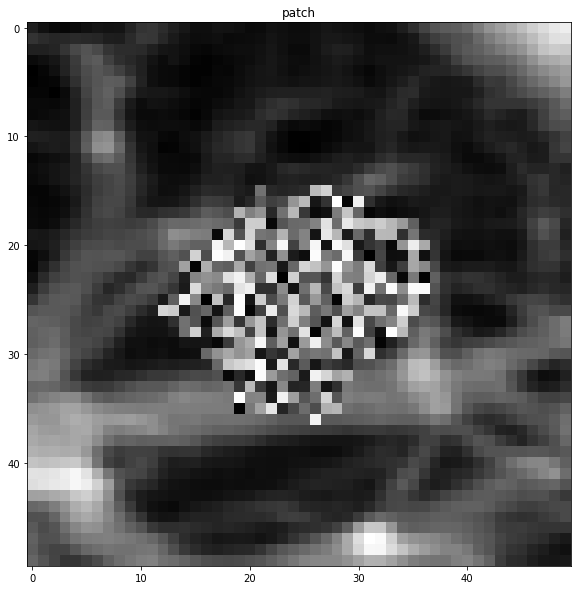

In [73]:
i = 0
result_output_folder = "./Data/masked_inputs/"


im = Image.fromarray(masked_cxr.astype('uint16'))

fig = plt.figure(figsize=(10, 10))
plt.imshow(im, cmap='gray')
plt.title('patch')

im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

In [63]:
### PART ON XRAY PNG'S ###

df = pd.read_csv('./Data/training_data/metadata.csv')
df.set_index("img_name", inplace=True)
df.head()

,height,original_name,width,x,y,dataset
img_name,,,,,,
1057.png,37,2114_IM-0743-4004.png,40,236,514,openi
915.png,54,216840111366964012487858717522009258191536006_...,47,605,507,padchest
687.png,59,00026287_008.png,50,221,592,chestxray14
540.png,45,00007366_000.png,45,794,325,chestxray14
70.png,76,2642_IM-1128-1001.png,60,509,645,openi


In [19]:
class BoundingBox:
    def __init__(self, x, y, w, h):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h


In [20]:
def csv_to_BBox(filename):
    #get bbox info from the csv
    bbox_info = df.loc[img_name]
    
    bbox_x = bbox_info['x']
    bbox_y = bbox_info['y']
    bbox_w = bbox_info['width']
    bbox_h = bbox_info['height']
    
    return BoundingBox(bbox_x, bbox_y, bbox_w, bbox_h)

In [21]:
def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int(box.x - box.w/2)
        xmax  = int(box.x + box.w/2)
        ymin  = int(box.y - box.h/2)
        ymax  = int(box.y + box.h/2) 
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

In [22]:
#next step load the x-rays and draw the bounding boxes around the nodules
img_name = '1000.png'
image_path = mpimg.imread(os.path.join('./Data/training_data/images/',img_name))

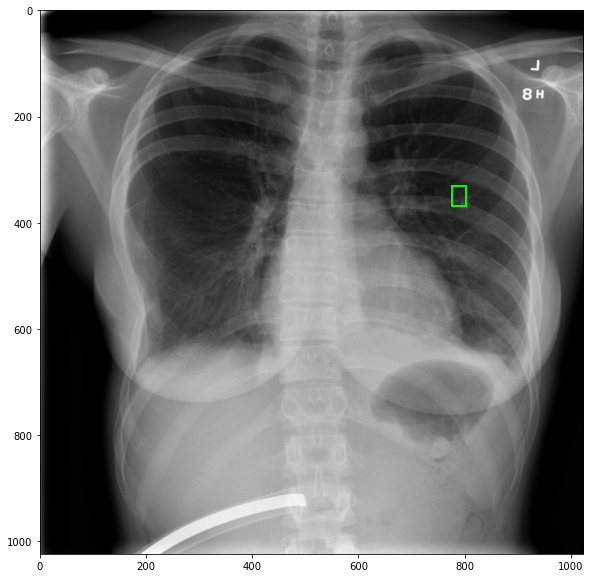

In [23]:
bbox = csv_to_BBox(img_name)
# get bounding boxes in matplotlib format
plt_boxes = get_matplotlib_boxes([bbox],image_path.shape)

# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image_path.squeeze(), cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

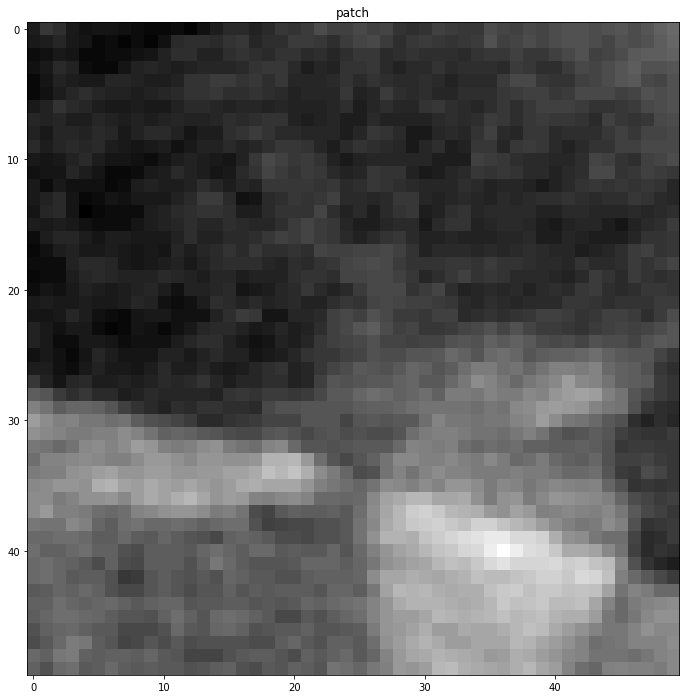

In [61]:
def get_patch(img, boxes):
    image = PIL.Image.open(img)
    image_sequence = image.getdata()
    image_array = np.array(image_sequence)
    image_array = np.reshape(image_array, (1024,1024))
    for box in boxes:
        xmin  = int(box.x - 25)
        xmax  = int(box.x + 25)
        ymin  = int(box.y - 25)
        ymax  = int(box.y + 25) 
        patch = np.array(image_array[ymin:ymax,xmin:xmax])
        #fig = plt.figure(figsize=(10, 10))
        plt.subplot(111)
        plt.imshow(patch, cmap='gray')
        plt.title('patch')
        return patch

img = get_patch(os.path.join('./Data/training_data/images/',img_name), [bbox])